#구글 코랩에 데이터셋(가위바위보) 내려받기

In [1]:
# 가위바위보 데이터셋 로드
import tensorflow as tf
import tensorflow_datasets as tfds

dataset, info = tfds.load('rock_paper_scissors', with_info=True, as_supervised=False)
train_dataset_original = dataset['train']
test_datasets = dataset['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2520 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.7B3RF5_3.0.0/rock_paper_scissors-train.tfre…

Generating test examples...:   0%|          | 0/372 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.7B3RF5_3.0.0/rock_paper_scissors-test.tfrec…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


In [2]:
# 훈련 및 검증 데이터셋 split 비율 설정
train_size = 0.85
train_count = int(info.splits['train'].num_examples * train_size)
valid_count = info.splits['train'].num_examples - train_count

In [3]:
# 훈련 데이터셋과 검증 데이터셋으로 나누기
train_datasets = train_dataset_original.take(train_count)
valid_datasets = train_dataset_original.skip(train_count)

In [4]:
# 각 데이터 셋 크기 확인
print(len(train_datasets))
print(len(valid_datasets))
print(len(test_datasets))

2142
378
372


In [5]:
# 훈련 데이터의 이미지 shpae와 label 확인
for data in train_datasets.take(5):
  print(data['image'].shape)
  print(data['label'])

(300, 300, 3)
tf.Tensor(2, shape=(), dtype=int64)
(300, 300, 3)
tf.Tensor(2, shape=(), dtype=int64)
(300, 300, 3)
tf.Tensor(0, shape=(), dtype=int64)
(300, 300, 3)
tf.Tensor(1, shape=(), dtype=int64)
(300, 300, 3)
tf.Tensor(0, shape=(), dtype=int64)


# 데이터 전처리

In [6]:
# 데이터 전처리 함수 생성
def preprocessing(data):
  image = tf.cast(data['image'], tf.float32) / 255.0
  label = data['label']
  return image, label

In [7]:
# 배치 사이즈 지정, 전처리 함수를 datasets에 매핑, 셔플 적용
BATCH_SIZE=32
train_data = train_datasets.map(preprocessing).shuffle(1000).batch(BATCH_SIZE)
valid_data = valid_datasets.map(preprocessing).batch(BATCH_SIZE)
test_data = test_datasets.map(preprocessing).batch(BATCH_SIZE)

In [8]:
# 데이터 증식 단계 정의
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

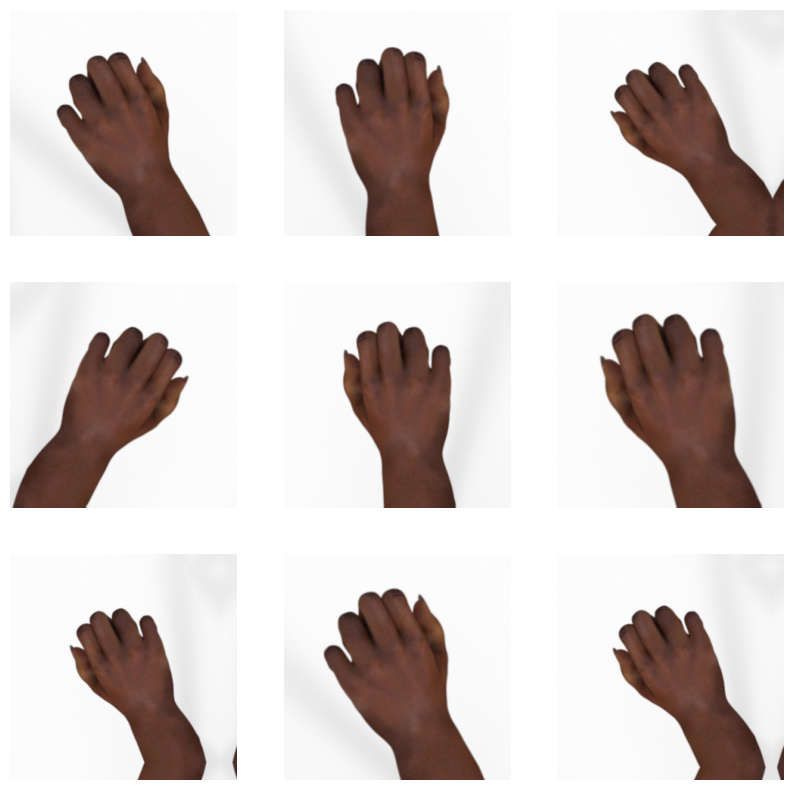

In [9]:
# 랜덤 증식된 훈련 이미지 출력하기
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for image, _ in train_data.take(1):
  for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_image[0].numpy().astype("float32"))
    plt.axis("off")

# 모델 만들기

In [10]:
# 모델 만들기
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(300, 300, 3))
x = data_augmentation(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [11]:
#모델 요약
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                        

In [12]:
# 모델 컴파일. 옵티마이저인 adam의 학습률 변경
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5) # Adam의 기본 learning rate 1e-3 -> 5e-5
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics="accuracy")

# 모델 훈련하기, 평가하기

In [13]:
# 콜백함수 및 훈련
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=3)
]
history = model.fit(
    train_data,
    validation_data=(valid_data),
    epochs=30,
    callbacks=callbacks)

Epoch 1/30
67/67 [==============================] - 28s 242ms/step - loss: 1.0814 - accuracy: 0.3810 - val_loss: 1.0220 - val_accuracy: 0.4735
Epoch 2/30
67/67 [==============================] - 8s 114ms/step - loss: 0.8560 - accuracy: 0.6190 - val_loss: 0.6683 - val_accuracy: 0.6323
Epoch 3/30
67/67 [==============================] - 7s 103ms/step - loss: 0.5135 - accuracy: 0.8016 - val_loss: 0.4153 - val_accuracy: 0.8148
Epoch 4/30
67/67 [==============================] - 8s 104ms/step - loss: 0.3268 - accuracy: 0.8875 - val_loss: 0.1433 - val_accuracy: 0.9709
Epoch 5/30
67/67 [==============================] - 8s 104ms/step - loss: 0.2385 - accuracy: 0.9122 - val_loss: 0.1214 - val_accuracy: 0.9656
Epoch 6/30
67/67 [==============================] - 8s 110ms/step - loss: 0.1829 - accuracy: 0.9463 - val_loss: 0.0752 - val_accuracy: 0.9841
Epoch 7/30
67/67 [==============================] - 8s 108ms/step - loss: 0.1977 - accuracy: 0.9388 - val_loss: 0.0957 - val_accuracy: 0.9656
Epoch

<Figure size 640x480 with 0 Axes>

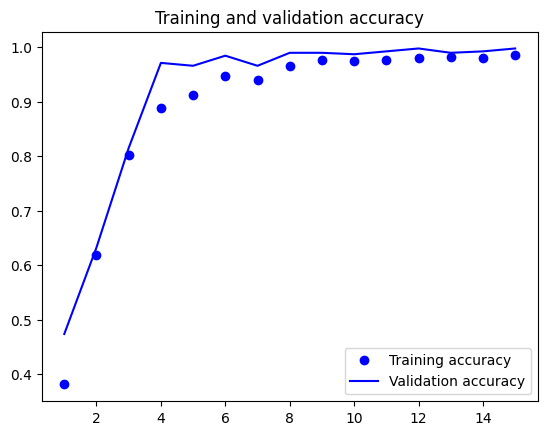

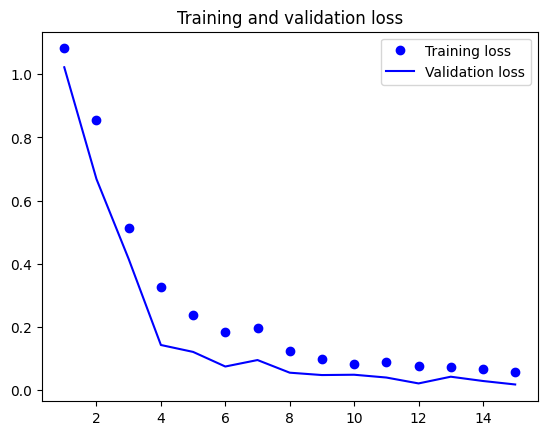

<Figure size 640x480 with 0 Axes>

In [14]:
# 훈련 과정 정확도, 손실 그래프 그리기
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy)+1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.figure()

In [15]:
# 테스트 세트에서 모델 평가하기
import time

test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
start_time = time.time()
test_loss, test_acc = test_model.evaluate(test_data)
end_time = time.time()
predict_time = end_time - start_time
print(f"테스트 정확도: {test_acc:.3f}")
print(f"predict time : {predict_time:.3f} s")

12/12 [==============================] - 2s 142ms/step - loss: 0.3545 - accuracy: 0.8844
테스트 정확도: 0.884
predict time : 2.903 s
